In [1]:
import numpy as np
np.set_printoptions(suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

from utils import *

In [2]:
def devide_bgr(img):
    m,n = img.shape
    n_rows = int(m//3)

    img_b = img[:n_rows]
    img_g = img[n_rows:n_rows*2]
    img_r = img[n_rows*2:n_rows*3]
    return img_b, img_g, img_r

def align_bgr(img_b, img_g, img_r, align_vec_g=(0,0), align_vec_r=(0, 0)):
    m, n = img_b.shape
    img_g_shift = shift_image(img_g, align_vec_g[0],  align_vec_g[1])
    img_r_shift = shift_image(img_r, align_vec_r[0],  align_vec_r[1])
    img_color = np.zeros((m,n,3))
    img_color[:,:,0] = img_r_shift
    img_color[:,:,1] = img_g_shift
    img_color[:,:,2] = img_b
    return img_color

def SSD(img_1, img_2, boundary_cropping=False):
    if img_1.shape != img_2.shape:
        raise Exception('Different shape %s, %s'%(img_1.shape, img_2.shape))
    diff = img_1 - img_2
    if boundary_cropping:
        m, n = diff.shape
        cy = int(m//10)
        cx = int(n//10)
        diff[:cy, :cx] = 0
        diff[:cy, -cx:]= 0
        diff[-cy:, :cx] = 0
        diff[-cy:, -cx:] = 0
        
    return np.sum(diff*diff)

In [3]:
def shift_image(X, sx, sy):
    X = np.roll(X, sy, axis=0)
    X = np.roll(X, sx, axis=1)
    if sy>0:
        X[:sy, :] = 0
    elif sy<0:
        X[sy:, :] = 0
    if sx>0:
        X[:, :sx] = 0
    elif sx<0:
        X[:, sx:] = 0
    return X

def devide_bgr(img):
    m,n = img.shape
    n_rows = int(m//3)

    img_b = img[:n_rows]
    img_g = img[n_rows:n_rows*2]
    img_r = img[n_rows*2:n_rows*3]
    return img_b, img_g, img_r

def align_bgr(img_b, img_g, img_r, align_vec_g=(0,0), align_vec_r=(0, 0)):
    m, n = img_b.shape
    img_g_shift = shift_image(img_g, align_vec_g[0],  align_vec_g[1])
    img_r_shift = shift_image(img_r, align_vec_r[0],  align_vec_r[1])
    img_color = np.zeros((m,n,3))
    img_color[:,:,0] = img_r_shift
    img_color[:,:,1] = img_g_shift
    img_color[:,:,2] = img_b
    return img_color

def SSD(img_1, img_2, boundary_cropping=True):
    if img_1.shape != img_2.shape:
        raise Exception('Different shape %s, %s'%(img_1.shape, img_2.shape))
    diff = img_1 - img_2
    if boundary_cropping:
        m, n = diff.shape
        cy = int(m//10)
        cx = int(n//10)
        diff[:cy, :cx] = 0
        diff[:cy, -cx:]= 0
        diff[-cy:, :cx] = 0
        diff[-cy:, -cx:] = 0
        
    return np.sum(diff*diff)


In [4]:
def get_similar(r, g, b, rad): 
    bg_similar = similarity(b, g, rad)
    br_similar = similarity(b, r, rad)
    return (bg_similar, br_similar)

def similarity(img_b, img, rad):
    mat = np.zeros((rad*2, rad*2))
    for i in range(-rad, rad):
        for j in range(-rad, rad):
                img_new = np.roll(img, i, axis=0)
                img_new = np.roll(img_new, j, axis=1)
                ssd_val = ssd(img_b, img_new)
                mat[i+rad, j+rad] = ssd_val

    lowest = mat.argmin() 
    row_shift = (lowest // (rad*2)) - rad ##check this part **
    col_shift = (lowest % (rad*2)) - rad ##check this part **
    return (row_shift, col_shift)

def ssd(img_1, img_2):
    ssd = np.sum((img_1 - img_2) **2)
    return ssd

In [5]:
def brute_force_colorize(img):
    print("img shape", img.shape)
    # compute the height of each channel of image (1/3 of total height)
    height = int(np.floor(img.shape[0] / 3.0))
    print('height: ', height)
    b, g, r = devide_bgr(img)

    b = crop(b)
    g = crop(g)
    r = crop(r)
    
    original_b, original_r, original_g = b, r, g

    # Applying sobel filter
    print('applying sobel filter...', end=' ')
    sobel_x, sobel_y = get_sobel_filter()
    b = convolution_2D(b, sobel_x)
    b = convolution_2D(b, sobel_y)
    g = convolution_2D(g, sobel_x)
    g = convolution_2D(g, sobel_y)
    r = convolution_2D(r, sobel_x)
    r = convolution_2D(r, sobel_y)
    print("finish sobel")
    
    # pyramid implementation 
    window_size = int(height // 5) 

    #compute similarity
    similar_result = get_similar(r, g, b, window_size)
    row_shift_g, col_shift_g = similar_result[0] #x, y shift for g
    row_shift_r, col_shift_r = similar_result[1] #x, y shift for r 

    # create a color image
    print('Green Align Vector: (%d, %d)'%(row_shift_g,  col_shift_g))
    print('Red Align Vector:   (%d, %d)'%(row_shift_r,  col_shift_r))
    original_g = shift_image(original_g, col_shift_g, row_shift_g)
    original_r = shift_image(original_r, col_shift_r, row_shift_r)

    img_out = np.dstack([original_r, original_g, original_b])

    # display the image
    plt.figure(figsize=(20,20))
    plt.imshow(img_out)
    plt.show()

    return img_out

img shape (1024, 390)
height:  341
applying sobel filter... finish sobel
Green Align Vector: (5, 2)
Red Align Vector:   (12, 3)


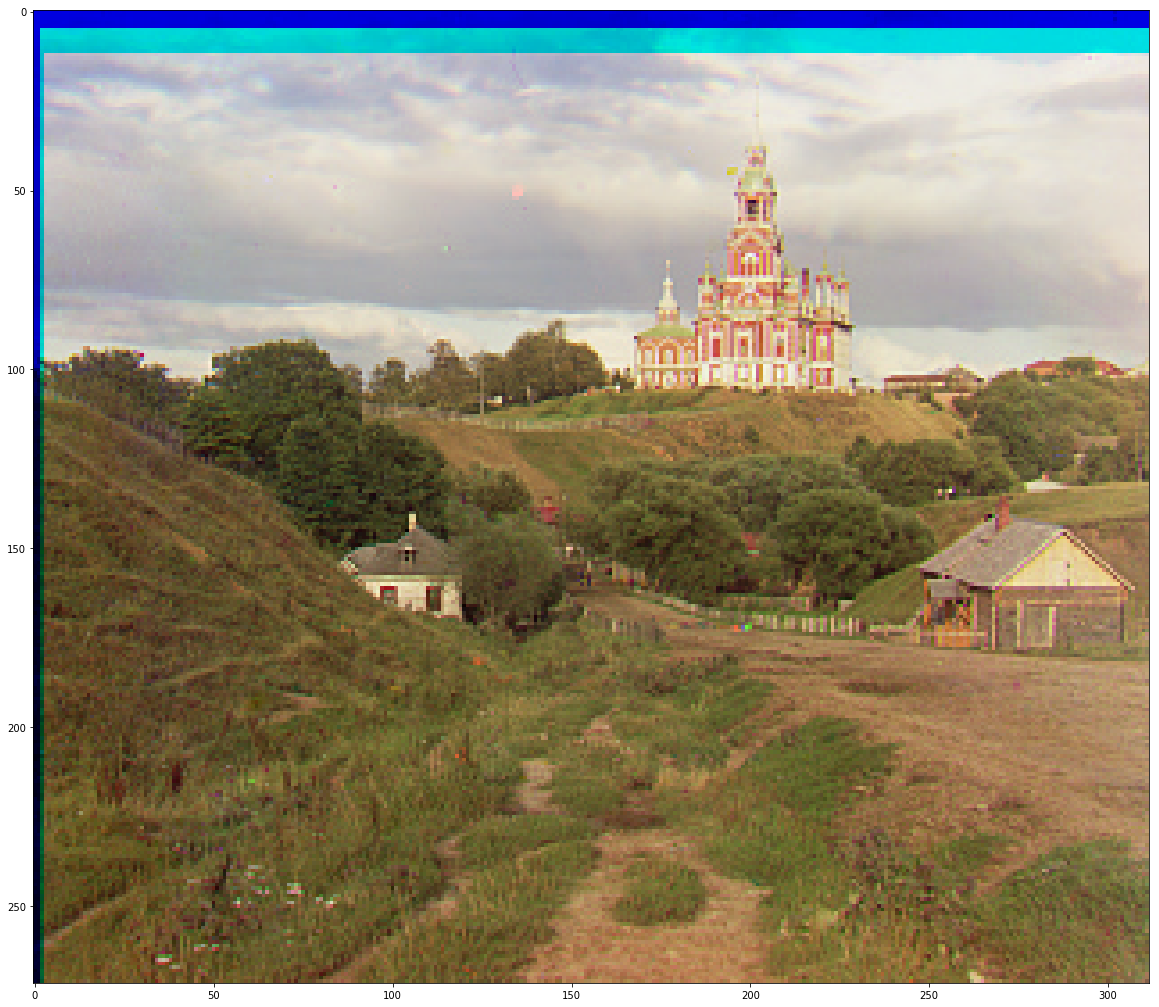

results/cathedral.png
img shape (1024, 391)
height:  341
applying sobel filter... finish sobel
Green Align Vector: (-3, 2)
Red Align Vector:   (3, 2)


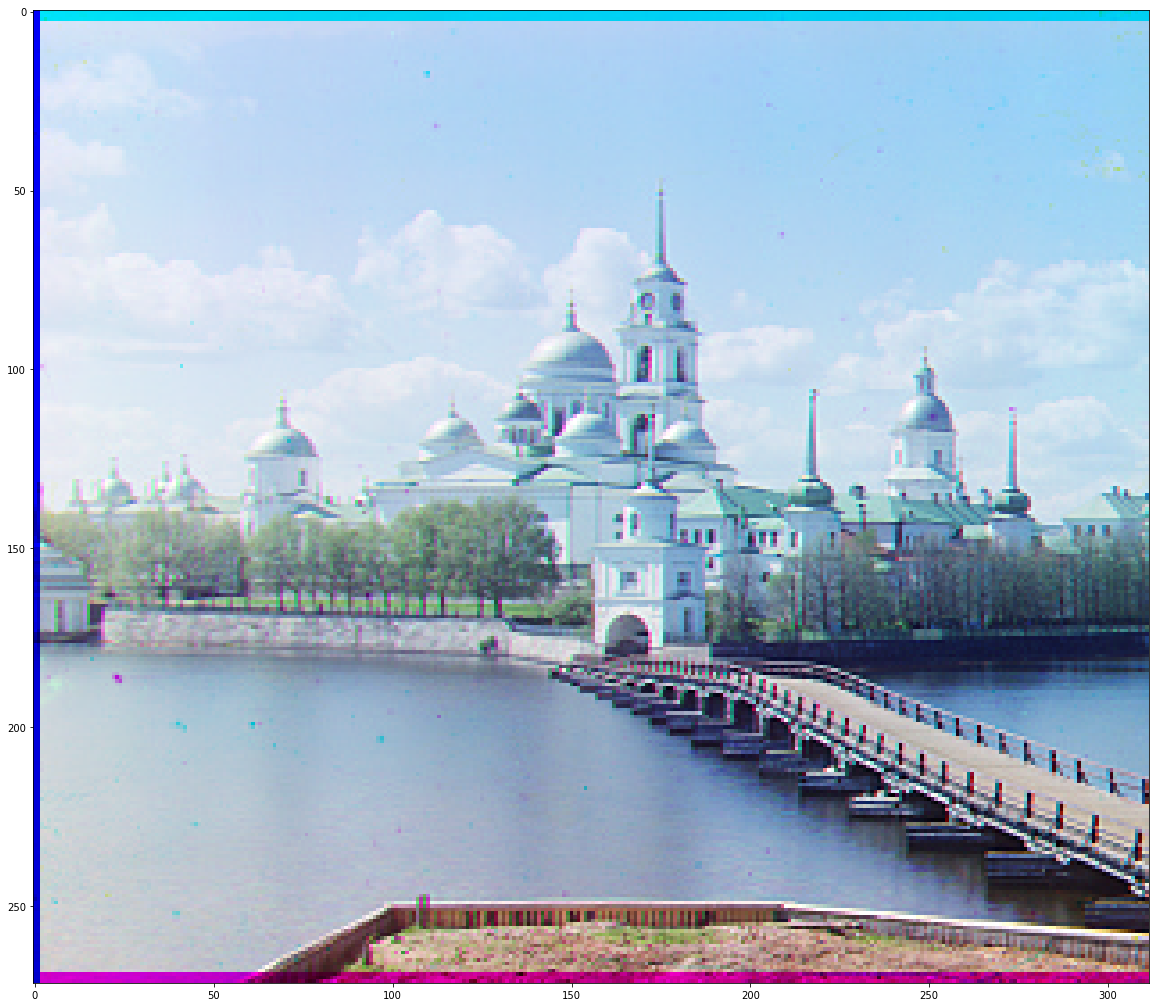

results/monastery.png
img shape (1024, 395)
height:  341
applying sobel filter... finish sobel
Green Align Vector: (3, 1)
Red Align Vector:   (8, 0)


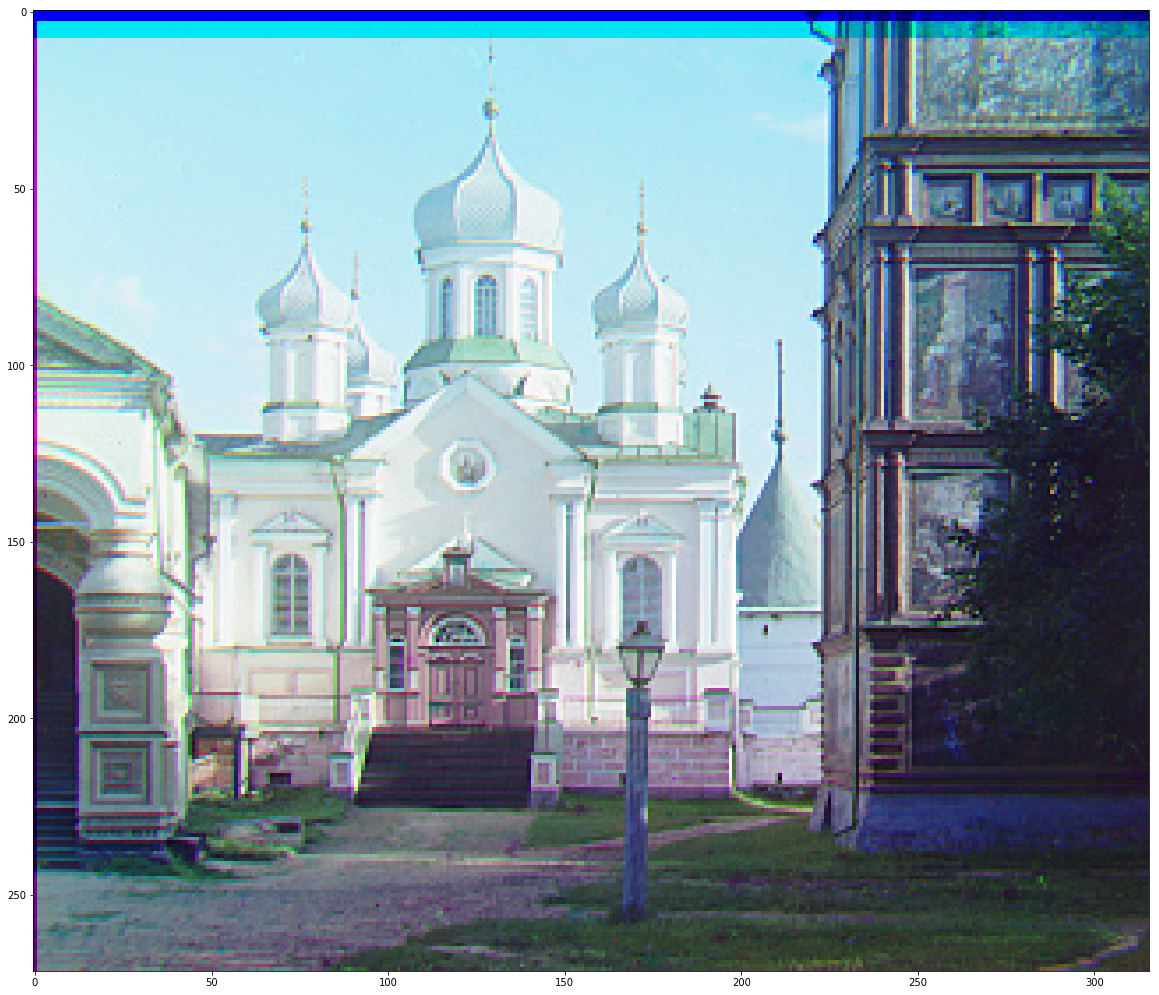

results/nativity.png
img shape (1024, 396)
height:  341
applying sobel filter... finish sobel
Green Align Vector: (3, 2)
Red Align Vector:   (6, 3)


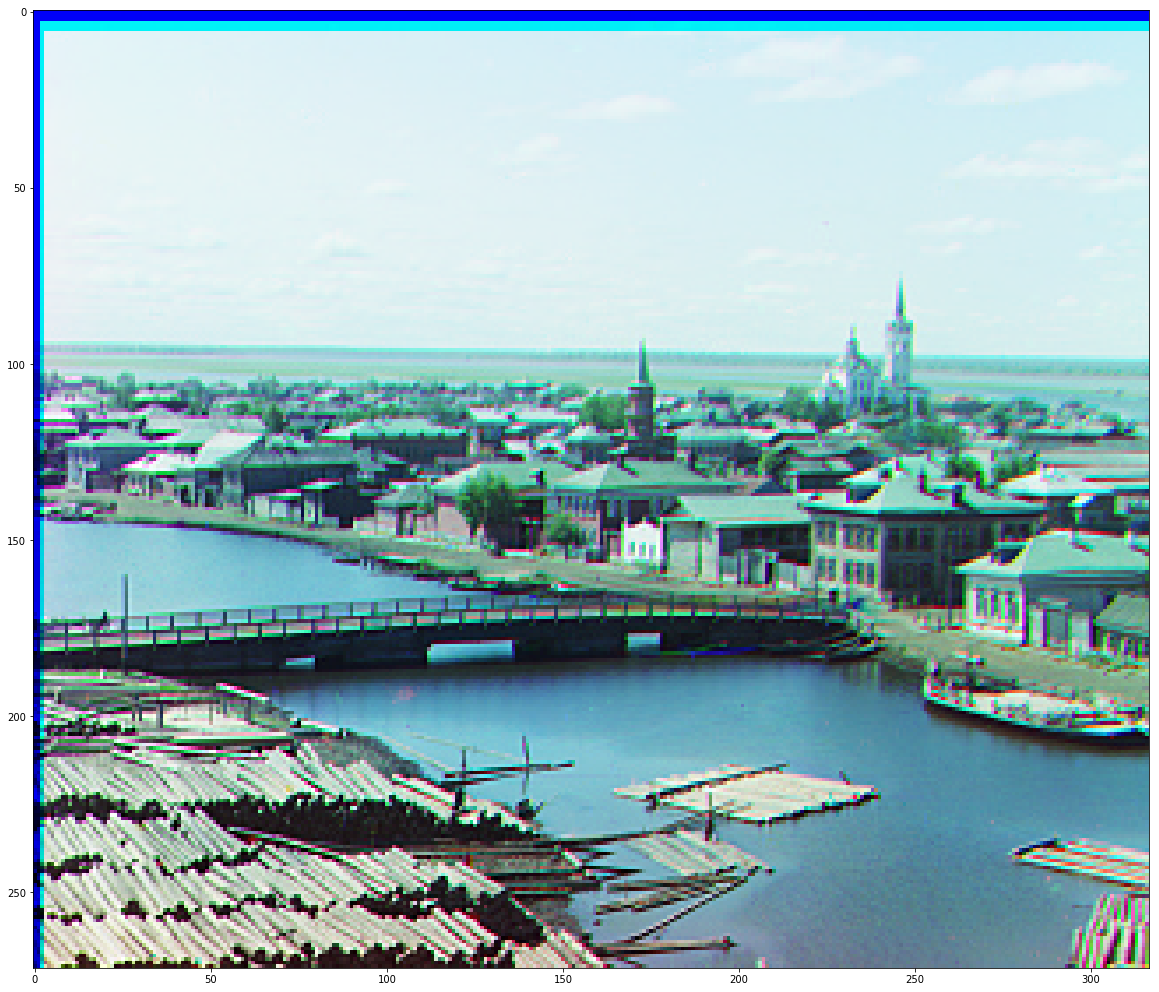

results/tobolsk.png


In [6]:
import glob
img_names = glob.glob("datas/*")
for img_name in img_names:
    img = cv2.imread(img_name, -1)
    m, n = img.shape
    if m < 2000:
        img = img / img.max()
        img_color = brute_force_colorize(img)
        save_name  = 'results/' + img_name.split('datas')[1][1:].split('.jpg')[0] + ".png"
        print(save_name)
        img_color = (img_color*255.0*255.0).astype(np.uint16)
        img_bgr = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_name, img_bgr)